<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Соревнование по прогнозированию популярности статьи на портале Medium
## <center> Ridge baseline

[Ссылка](https://mlcourse.arktur.io/) на соревнование.

**Задача** 

Есть выборка статей с популярного англоязычного портала Medium. Задача – спрогнозировать число рекомендаций ("лайков") статьи.
Предлагается Вам самим составить обучающую и тестовую выборки на основе имеющихся данных, обучить модель-регрессор и сформировать файл посылки с прогнозами – числом рекомендаций статей (с `log1p`-преобразованием) из тестовой выборки.

**Данные**

Обучающая выборка – 52699 статей, опубликованных до 2016 года включительно (**train.zip** ~ 480 Mb, unzip ~1.6 Gb). Тестовая выборка – 39492 статьи, опубликованные с 1 января по 27 июня 2017 года (**test.zip** ~425 Mb, unzip ~1.4 Gb).

Данные о статьях представлены в JSON формате с полями:
- _id и url – URL статьи
- published – время публикации
- title – название статьи
- author – имя автора, его акканут на Твиттере и Medium
- content – HTML-контент статьи
meta_tags – остальная информация о статье

В файле **train_log1p_recommends.csv** представлены номера (id) статей из обучающей выборки вместе с целевым показателем: числом рекомендаций статей, к которому применено преобразование `log1p(x) = log(1 + x)`. В файле **sample_submission.csv** представлен пример файла посылки.

In [1]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

In [2]:
PATH_TO_DATA = '../../data/'

Следующий код я стащил откуда-то со StackOverflow – он выкидывает из текста HTML-теги.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Готовим обучающую и тестовую выборки. Забираем из JSON-представления статьи только content (собственно текст статьи), очищаем его от HTML-тегов и записываем в файл. Такой формат подойдет для извлечения признаков (Bag of Words) с помощью `CountVectorizer`. На Mac с SSD это все работает относительно быстро, на Windows без SSD будет скучновато.

In [66]:
with open(os.path.join(PATH_TO_DATA, 'train.json')) as inp_json_file, \
     open(os.path.join(PATH_TO_DATA, 'train_raw_content.txt'), 'w') \
     as out_raw_text_file:
            
    for line in tqdm_notebook(inp_json_file):
        json_data = json.loads(line)
        content = json_data['content'].replace('\n', ' ')
        content_no_html_tags = strip_tags(content)
        out_raw_text_file.write(content_no_html_tags + '\n')

In [67]:
!wc -l $PATH_TO_DATA/train_raw_content.txt

   52699 train_raw_content.txt


In [68]:
with open(os.path.join(PATH_TO_DATA, 'test.json')) as inp_json_file, \
     open(os.path.join(PATH_TO_DATA, 'test_raw_content.txt'), 'w') \
     as out_raw_text_file:
            
    for line in tqdm_notebook(inp_json_file):
        json_data = json.loads(line)
        content = json_data['content'].replace('\n', ' ')
        content_no_html_tags = strip_tags(content)
        out_raw_text_file.write(content_no_html_tags + '\n')

In [69]:
!wc -l $PATH_TO_DATA/test_raw_content.txt

   39492 test_raw_content.txt


Долго возился с этим багом – `CountVectorizer` возвращал больше строк, чем надо, из-за ^M (возврата каретки) – следующий код, тоже позаимствованный откуда до со StackOverflow, убирает эти символы. Черт побери... перл. Но работает быстро :)

In [36]:
!perl -p -i -e "s/\r//g" $PATH_TO_DATAtrain_raw_content.txt
!perl -p -i -e "s/\r//g" $PATH_TO_DATAtest_raw_content.txt

Теперь как раз применяем `CountVectorizer`. 

In [3]:
cv = CountVectorizer(max_features=100000)

In [4]:
%%time
with open(os.path.join(PATH_TO_DATA, 
                       'train_raw_content.txt')) as input_train_file:
    X_train = cv.fit_transform(input_train_file)

CPU times: user 48 s, sys: 1.2 s, total: 49.2 s
Wall time: 49.3 s


In [5]:
X_train.shape

(52699, 100000)

In [6]:
%%time
with open(os.path.join(PATH_TO_DATA, 
                       'test_raw_content.txt')) as input_test_file:
    X_test = cv.transform(input_test_file)

CPU times: user 29.9 s, sys: 457 ms, total: 30.3 s
Wall time: 30.4 s


In [7]:
X_test.shape

(39492, 100000)

Считываем ответы на обучающей выборке.

In [8]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), 
                           index_col='id')

In [9]:
y_train = train_target['log_recommends'].values

Будем смотреть на качество (MAE) на 30% данных, причем не перемешиваем данные, а соблюдаем время – проверочная часть четко по времени после обучающей.

In [10]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Посмотрим на распределение логарифма целевого признака. То есть это уже 2 логарифма от числа рекомендаций статьи.

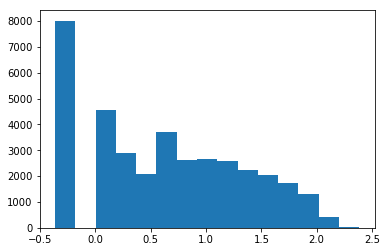

In [11]:
plt.hist(np.log(y_train_part), bins=15);

Обучаем Ridge-регрессию без настройки гиперпараметров на 70% исходной обучающей выборки.

In [12]:
from sklearn.linear_model import Ridge

In [13]:
ridge_reg = Ridge(random_state=17)

In [21]:
%%time
ridge_reg.fit(X_train_part, y_train_part)

CPU times: user 2min 31s, sys: 662 ms, total: 2min 32s
Wall time: 2min 32s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [22]:
ridge_valid_pred = ridge_reg.predict(X_valid)

In [24]:
mean_absolute_error(y_valid, ridge_valid_pred)

1.2470396394081305

Получили MAE $\approx$ 1.25. Если вренуться к числу рекомендаций статьи, то ошибаемся в среднем на 2.5 единицы. Теперь обучаем такую же модель, но на всей обчающей выборке.

In [25]:
%%time
ridge_reg.fit(X_train, y_train)

CPU times: user 3min 31s, sys: 1.66 s, total: 3min 32s
Wall time: 3min 34s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

Делаем прогноз для тестовой выборки.

In [26]:
%%time
ridge_test_pred = ridge_reg.predict(X_test)

CPU times: user 62.2 ms, sys: 128 ms, total: 190 ms
Wall time: 191 ms


Записываем прогнозы в файл. 

In [29]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA,
                                        'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [30]:
write_submission_file(ridge_test_pred, 
                      os.path.join(PATH_TO_DATA, 'first_ridge.csv'))

Если сделать посылку на [сайте](https://mlcourse.arktur.io/dashboard?problem=MLCourse) соревнования, то получится воспроизведение бенчмарка "Content only, Ridge + CountVectorizer".